In [ ]:
!python -m spacy download en_core_web_md

In [ ]:
!pip install nltk

In [2]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
from dateutil import parser
import missingno as msno
import re
from scipy.stats import mode
import spacy
import tqdm
import pickle
from bs4 import BeautifulSoup
from spacy.matcher import Matcher
import networkx as nx
import nltk
from nltk import TreebankWordTokenizer,WordPunctTokenizer
from nltk.tokenize import word_tokenize,PunktSentenceTokenizer

In [2]:
pd.set_option("display.max_column",500)
pd.set_option("display.max_rows",500)
sns.set(style="darkgrid")
sns.set_context("talk")

In [3]:
#load data
data=pd.read_csv(r"E:\Python\Msc-AI-Projects\loan.csv",low_memory=False)

In [4]:
#Function to create meta data of the data
def create_Meta(data):
    meta_data={'dtypes':data.dtypes,
              'missing_values':round(data.isna().sum()*100/data.shape[0],3),
              'count':[data[i].count() for i in data.columns.values],
              'Number_Uniques':[data[i].nunique() for i in data.columns.values]}
    return pd.DataFrame(meta_data)

In [5]:
Meta_Data=create_Meta(data)

In [63]:
#Display meta data of our data
Meta_Data.to_clipboard()

In [7]:
#Sorting Meta Data on the basis of missing value percentage in descending order
Meta_Data=Meta_Data.sort_values(by='missing_values',ascending=False)

In [8]:
#Slicing Meta Data on basis of missing value percentage which shall be greater than 30%
Meta_Data[Meta_Data['missing_values']>30]

,dtypes,missing_values,count,Number_Uniques
verification_status_joint,float64,100.000,0,0
annual_inc_joint,float64,100.000,0,0
mo_sin_old_rev_tl_op,float64,100.000,0,0
mo_sin_old_il_acct,float64,100.000,0,0
bc_util,float64,100.000,0,0
bc_open_to_buy,float64,100.000,0,0
avg_cur_bal,float64,100.000,0,0
acc_open_past_24mths,float64,100.000,0,0
inq_last_12m,float64,100.000,0,0
total_cu_tl,float64,100.000,0,0


### Missing Value Treatment

In [9]:
#We have noticed that there are many columns which have more than 90 percent missing values
# There are columns which have 30% and 64% missing values also . 
#We will drop columns having missing values more than 50% and for rest we will explore and then take a call
missing_value_columns=Meta_Data[Meta_Data['missing_values']>50].index

In [10]:
#Dropped missing value columns
ft_data=data.drop(missing_value_columns,axis=1)

In [11]:
#Shape after and before dropping missing value columns
#We notice that 50% approx columns have been dropped
ft_data.shape,data.shape

((39717, 54), (39717, 111))

In [12]:
ft_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0,Jan-85,1,3,0,13648,83.70%,9,f,0.00,0.00,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.00,Jan-15,171.62,May-16,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0,Apr-99,5,3,0,1687,9.40%,4,f,0.00,0.00,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,Sep-13,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,real estate business,606xx,IL,8.72,0,Nov-01,2,2,0,2956,98.50%,10,f,0.00,0.00,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.00,Jun-14,649.91,May-16,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0,Feb-96,1,10,0,5598,21%,37,f,0.00,0.00,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,0.00,Jan-15,357.48,Apr-16,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-11,Current,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0,Jan-96,0,15,0,27783,53.90%,38,f,524.06,524.06,3513.330000,3513.33,2475.94,1037.39,0.00,0.00,0.00,May-16,67.79,May-16,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0


In [13]:
def find_pattern(x):
    r=r"[0-9]"
    start,end=re.search(r,x).span()
    x=x[start:end+1]
    return x

In [14]:
indx=ft_data[ft_data["emp_length"].notnull()]['emp_length'].index.values.tolist()
ft_data['emp_length'].loc[indx,]=ft_data['emp_length'].loc[indx,].map(find_pattern)

In [15]:
#data cleaning
def data_split(a,x,y):
    b=a.split(x)[y]
    return b

ft_data['term']=ft_data.term.apply(data_split,args=(" ",1))


In [16]:
ft_data["int_rate"]=ft_data.int_rate.apply(data_split,args=("%",0))

In [17]:

# ft_data['emp_length'].loc[indx,]=ft_data['emp_length'].loc[indx,].apply(data_split,args=("+",0))
indx=ft_data[ft_data["revol_util"].notnull()]['revol_util'].index.values.tolist()
ft_data['revol_util'].loc[indx,]=ft_data['revol_util'].loc[indx,].apply(data_split,args=("%",0))

In [18]:
#Checking if missing data is not at Random
#Creating dichotomous column for missing variable,1->missing,0->not missing
ft_data['desc_isMissing']=np.where(ft_data['desc'].isna(),1,0)
ft_data['emp_title_isMissing']=np.where(ft_data['emp_title'].isna(),1,0)
ft_data['emp_length_isMissing']=np.where(ft_data['emp_length'].isna(),1,0)

In [19]:
ft_data.loan_status.value_counts()

Fully Paid     32950
Charged Off     5627
Current         1140
Name: loan_status, dtype: int64

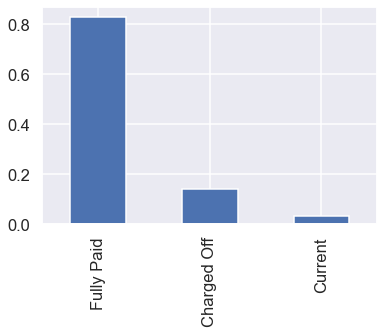

In [20]:
#We find that 80% of description of loan provided by borrower is missing for those who have fully paid 
ft_data[ft_data.desc_isMissing==1]['loan_status'].value_counts(normalize=True).plot(kind='bar')
plt.show()

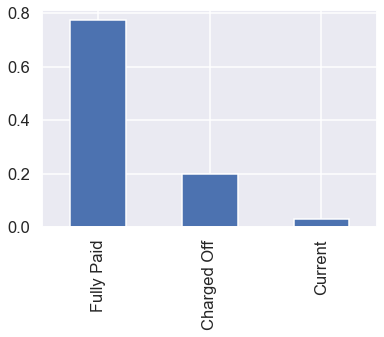

In [21]:
#We find that 80% of job title provided by borrower is missing for those who have fully paid
ft_data[ft_data.emp_title_isMissing==1]['loan_status'].value_counts(normalize=True).plot(kind='bar')
plt.show()

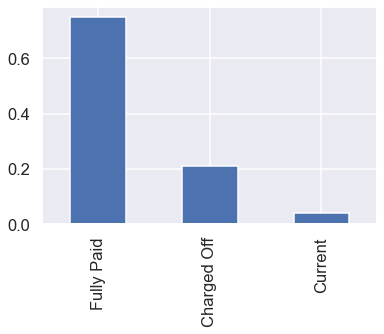

In [22]:
#We find that 70% of job tenure provided by borrower is missing for those who have fully paid
ft_data[ft_data.emp_length_isMissing==1]['loan_status'].value_counts(normalize=True).plot(kind='bar')
plt.show()

It has been seen that majority of the missing data are of those who have fully paid, that is those who are likely to fully pay the loan amount. Hence we can say that the missing data is not at random. There is a clear pattern which we can see

In [23]:
descMissing_data=ft_data[ft_data.desc_isMissing==1]

In [24]:
descMissing_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,desc_isMissing,emp_title_isMissing,emp_length_isMissing
2,1077175,1313524,2400,2400,2400.0,36,15.96,84.33,C,C5,NaN,10,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,real estate business,606xx,IL,8.72,0,Nov-01,2,2,0,2956,98.50,10,f,0.0,0.0,3005.666844,3005.67,2400.00,605.67,0.0,0.0,0.0000,Jun-14,649.91,May-16,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0,1,1,0
5,1075269,1311441,5000,5000,5000.0,36,7.90,156.46,A,A4,Veolia Transportaton,3,RENT,36000.0,Source Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,wedding,My wedding loan I promise to pay back,852xx,AZ,11.20,0,Nov-04,3,9,0,7963,28.30,12,f,0.0,0.0,5632.210000,5632.21,5000.00,632.21,0.0,0.0,0.0000,Jan-15,161.03,Jan-16,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0,1,0,0
11,1069908,1305008,12000,12000,12000.0,36,12.69,402.54,B,B5,UCLA,10,OWN,75000.0,Source Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Consolidation,913xx,CA,10.78,0,Oct-89,0,12,0,23336,67.10,34,f,0.0,0.0,13947.989160,13947.99,12000.00,1947.99,0.0,0.0,0.0000,Sep-13,6315.30,Aug-13,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0,1,0,0
14,1069057,1303503,10000,10000,10000.0,36,10.65,325.74,B,B2,SFMTA,3,RENT,100000.0,Source Verified,Dec-11,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,other,Other Loan,951xx,CA,7.06,0,May-91,2,14,0,11997,55.50,29,f,0.0,0.0,7471.990000,7471.99,5433.47,1393.42,0.0,645.1,6.3145,Oct-13,325.74,Mar-14,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0,1,0,0
15,1069759,1304871,1000,1000,1000.0,36,16.29,35.31,D,D1,Internal revenue Service,1,RENT,28000.0,Not Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt Consolidation Loan,641xx,MO,20.31,0,Sep-07,1,11,0,6524,81.50,23,f,0.0,0.0,1270.716942,1270.72,1000.00,270.72,0.0,0.0,0.0000,Jan-15,36.32,May-16,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0,1,0,0


In [25]:
print(descMissing_data.loan_amnt.mean(),ft_data[ft_data.desc_isMissing==0]['loan_amnt'].mean(),ft_data['loan_amnt'].mean())

10585.99884080371 11525.55644769765 11219.443814991062


In [26]:
print(descMissing_data.funded_amnt.mean(),ft_data[ft_data.desc_isMissing==0]['funded_amnt'].mean(),ft_data['funded_amnt'].mean())

10373.154945904173 11225.368786645255 10947.713195860715


In [27]:
descMissing_data.term.value_counts()

36    9248
60    3692
Name: term, dtype: int64

In [28]:
ft_data[ft_data.desc_isMissing==0]['term'].value_counts()

36    19848
60     6929
Name: term, dtype: int64

We see that distribution of term on the basis of description missing and not missing are similar that is loan applicants prefference for 3 years is twice more than of 5 years

In [29]:
ft_data.int_rate=ft_data.int_rate.astype('float64')
descMissing_data.int_rate=descMissing_data.int_rate.astype('float64')
print(descMissing_data.int_rate.mean(),ft_data[ft_data.desc_isMissing==0].int_rate.mean(),ft_data.int_rate.mean())

11.995565687789716 12.033553049259668 12.02117657426169


In [30]:
ft_data.emp_length=ft_data.emp_length.astype('float64')
descMissing_data.emp_length=descMissing_data.emp_length.astype('float64')
print(descMissing_data.emp_length.mean(),ft_data[ft_data.desc_isMissing==0].emp_length.mean(),ft_data.emp_length.mean())

5.37983193277311 4.95452633189276 5.092050100926453


In [31]:
ft_data.revol_util=ft_data.revol_util.astype('float64')
descMissing_data.revol_util=descMissing_data.revol_util.astype('float64')
print(descMissing_data.revol_util.mean(),ft_data[ft_data.desc_isMissing==0].revol_util.mean(),ft_data.revol_util.mean())

49.29169606932862 48.610070298770054 48.83215241888721


No clear pattern in interest rate, revol util and employee length seen for missing description and non missing data 

In [32]:
#Try Finding Employee Length based on Title and imputing the missings
title_wise_empLen=ft_data.groupby('emp_title',as_index=False,dropna=True)['emp_length'].median()

In [33]:
emp_title_NA_Length=ft_data[(~ft_data.emp_title.isna())&(ft_data.emp_length.isna())]['emp_title'].values.tolist()

In [34]:
a=pd.DataFrame()
for i in emp_title_NA_Length:
    a=pd.concat([a,title_wise_empLen[title_wise_empLen.emp_title==i]],axis=0)

In [35]:
emp_title=a[~a.emp_length.isna()].emp_title.tolist()

In [36]:
indexes=[]
for i in emp_title:
    ind=ft_data[(ft_data.emp_title==i)&(ft_data.emp_length.isna())]['emp_length'].index.values[0]
    indexes.append(ind)

In [37]:
indexes

[5936, 6631, 7661, 19179, 20772, 22816, 25010, 25322, 26181, 29984, 31126]

In [38]:
missing_emp_length_data=ft_data.loc[indexes,:]
emp_lnt=a[~a.emp_length.isna()].emp_length.tolist()    
missing_emp_length_data.loc[:,'emp_length']=emp_lnt


In [39]:
ft_data=pd.concat([ft_data.drop(indexes,axis=0),missing_emp_length_data],axis=0)

In [40]:
ft_data.reset_index(drop=True,inplace=True)

In [41]:
indexes=ft_data[(ft_data.emp_length.isna())].index.values.tolist()

In [42]:
#Dropping rows where emp_length is NA
ft_data.drop(indexes,axis=0,inplace=True)

In [43]:
ft_data.isna().sum()*100/ft_data.shape[0]

id                             0.000000
member_id                      0.000000
loan_amnt                      0.000000
funded_amnt                    0.000000
funded_amnt_inv                0.000000
term                           0.000000
int_rate                       0.000000
installment                    0.000000
grade                          0.000000
sub_grade                      0.000000
emp_title                      3.725455
emp_length                     0.000000
home_ownership                 0.000000
annual_inc                     0.000000
verification_status            0.000000
issue_d                        0.000000
loan_status                    0.000000
pymnt_plan                     0.000000
url                            0.000000
desc                          32.339016
purpose                        0.000000
title                          0.025871
zip_code                       0.000000
addr_state                     0.000000
dti                            0.000000


In [44]:
#Grouping employee title most frequent based on employee experience
#Treating Missing Values of Employee title
empTitle_by_Length=ft_data.groupby("emp_length",as_index=False).agg({"emp_title":mode})
for i in range(len(empTitle_by_Length)):
    empTitle_by_Length.emp_title[i]=empTitle_by_Length.emp_title[i].mode[0]

In [45]:
empTitle_by_Length

,emp_length,emp_title
0,1.0,Bank of America
1,2.0,Bank of America
2,3.0,Kaiser Permanente
3,4.0,Self Employed
4,5.0,Verizon Wireless
5,6.0,US Army
6,7.0,US Army
7,8.0,US Army
8,9.0,UPS
9,9.5,Honeywell


In [46]:
indexes=ft_data[ft_data.emp_title.isna()].index.values.tolist()
empTitle_NAdata=ft_data.loc[indexes,:]
empTitle_NAdata[(empTitle_NAdata.emp_length==1.0)&(empTitle_NAdata.emp_title.isna())]["emp_title"].replace(np.nan,"Bank of America",inplace=True)

In [47]:
empTitle_NAdata.emp_length.value_counts().sum()

1440

In [48]:
#Imputation of missing values in employee title based on employee length
a=pd.DataFrame()
for i in empTitle_NAdata.emp_length.unique().tolist():
    dummy=empTitle_NAdata[(empTitle_NAdata.emp_length==i)&(empTitle_NAdata.emp_title.isna())]
    dummy.emp_title.replace(np.nan,empTitle_by_Length[empTitle_by_Length.emp_length==i].emp_title.values[0],inplace=True)
    a=pd.concat([dummy,a],axis=0)
    
ft_data=pd.concat([ft_data.drop(indexes,axis=0),a],axis=0)

In [49]:
ft_data.isna().sum()*100/ft_data.shape[0]

id                             0.000000
member_id                      0.000000
loan_amnt                      0.000000
funded_amnt                    0.000000
funded_amnt_inv                0.000000
term                           0.000000
int_rate                       0.000000
installment                    0.000000
grade                          0.000000
sub_grade                      0.000000
emp_title                      0.000000
emp_length                     0.000000
home_ownership                 0.000000
annual_inc                     0.000000
verification_status            0.000000
issue_d                        0.000000
loan_status                    0.000000
pymnt_plan                     0.000000
url                            0.000000
desc                          32.339016
purpose                        0.000000
title                          0.025871
zip_code                       0.000000
addr_state                     0.000000
dti                            0.000000


In [50]:
#Identifying patterns and treating null values in pub_rec_bankcruptcies
ft_data['pub_rec_bankruptcies'].value_counts(dropna=False)

0.0    36386
1.0     1563
NaN      697
2.0        7
Name: pub_rec_bankruptcies, dtype: int64

In [51]:
ft_data.groupby('pub_rec_bankruptcies',dropna=False).agg({'loan_status':np.count_nonzero})

,loan_status
pub_rec_bankruptcies,
0.0,36386
1.0,1563
2.0,7
NaN,697


In [52]:
#We notice the 697 missing public record of bankcruptcies are not the ones which are either charged off or who have fully paid..
#They belong to Current loan applicants
#Either this NaN can be another category itself or they belong to one specific category
ft_data[ft_data['pub_rec_bankruptcies'].isna()].groupby("loan_status",dropna=False)["pub_rec_bankruptcies"].count()

loan_status
Charged Off    0
Fully Paid     0
Name: pub_rec_bankruptcies, dtype: int64

In [53]:
#Understanding the behavior of bunkcruptcies on basis of average loan amount
#We see that those who have frequently shown bankcruptcies are the ones who have applied for high loan amounts. 
#The missing 697 are the ones which have applied for least loan amount
ft_data.groupby('pub_rec_bankruptcies',dropna=False).agg({'loan_amnt':'mean'})

,loan_amnt
pub_rec_bankruptcies,
0.0,11367.429094
1.0,10094.369802
2.0,12800.000000
NaN,9956.420373


In [54]:
#Understanding the behavior of bunkcruptcies on basis of average funded amount
#There is difference in loan applied amount and funded amount
#We see that those who do not have bankcruptcies or who have maximum record of bankcruptcies that is 2 have the highest amount funded. 
#The missing 697 are the ones which have got lesser funded amount
ft_data.groupby('pub_rec_bankruptcies',dropna=False).agg({'funded_amnt':'mean'})

,funded_amnt
pub_rec_bankruptcies,
0.0,11090.209146
1.0,9815.962892
2.0,12453.571429
NaN,9829.878049


In [55]:
#Understanding the behavior of bunkcruptcies on basis of average loan amount and loan status
#We see for all the number of bankcruptcies, people who have fully paid are the ones who have applied for the least amount and those who are current have the highest loan amount.
#For NAN category those whose loan is being charged off has the highest loan amount 
ft_data.groupby(['pub_rec_bankruptcies','loan_status'],dropna=False).agg({'loan_amnt':'mean'})

loan_amnt
pub_rec_bankruptcies loan_status              
0.0                  Charged Off  12274.934290
                     Current      17307.260338
                     Fully Paid   11011.605379
1.0                  Charged Off  11677.388060
                     Current      13053.030303
                     Fully Paid    9568.891213
2.0                  Charged Off  12500.000000
                     Current      25000.000000
                     Fully Paid    4866.666667
NaN                  Charged Off  12590.042373
                     Fully Paid    9419.689119

In [56]:
#Understanding the behavior of bunkcruptcies on basis of average loan amount and loan status
#We see for all the number of bankcruptcies, people who have fully paid are in majority numbers and the current applicants are the least
#Of NaNs i.e 697 applicants 83% are already paid off and only 17% have been charged of
ft_data.groupby(['pub_rec_bankruptcies','loan_status'],dropna=False).agg({'loan_amnt':'count'})

loan_amnt
pub_rec_bankruptcies loan_status           
0.0                  Charged Off       4946
                     Current           1064
                     Fully Paid       30376
1.0                  Charged Off        335
                     Current             33
                     Fully Paid        1195
2.0                  Charged Off          2
                     Current              2
                     Fully Paid           3
NaN                  Charged Off        118
                     Fully Paid         579

In [57]:
#Understanding the behavior of bunkcruptcies on basis of average interest rate
#We see that as the number of bankruptcies increases, it increases when the average interest rate rises. 
#The missing 697 have the least interest rate @11% approximately
ft_data.groupby('pub_rec_bankruptcies',dropna=False).agg({'int_rate':'mean'})

,int_rate
pub_rec_bankruptcies,
0.0,12.014279
1.0,13.539264
2.0,15.971429
NaN,10.640230


In [58]:
#Understanding the behavior of bunkcruptcies on basis of average loan amount and installment amount
#We see for all the number of bankcruptcies, people who have public record of bankcruptcies as two, pays highest isntallment
#For NAN category the installment is lesser comparatively
ft_data.groupby(['pub_rec_bankruptcies'],dropna=False).agg({'installment':'mean'})

,installment
pub_rec_bankruptcies,
0.0,328.144650
1.0,295.598298
2.0,373.270000
NaN,322.301119


In [59]:
#We see for zero and NaN category of the public record of bankcruptcies, majority of the applicants have home ownership as Rent and then Mortgage
#Those who displays bankcruptcies have higher frequencies of martgage as home ownership
ft_data.groupby(["pub_rec_bankruptcies","home_ownership"],dropna=False).agg({"emp_title":"count"})

emp_title
pub_rec_bankruptcies home_ownership           
0.0                  MORTGAGE            16136
                     OTHER                  95
                     OWN                  2683
                     RENT                17472
1.0                  MORTGAGE              822
                     OTHER                   3
                     OWN                    99
                     RENT                  639
2.0                  MORTGAGE                6
                     RENT                    1
NaN                  MORTGAGE              252
                     NONE                    3
                     OWN                    62
                     RENT                  380

In [60]:
#Since the patterns seen above we see lot of similarities in NaN category and bankcruotcies class 0 , which is suggestive of that applicants who are having public_bankcrupticies as NaN have zero bankcruptcies
#Hence We can impute NaNs with 0
ft_data.pub_rec_bankruptcies.fillna(0.0,inplace=True)

In [61]:
ft_data.isna().sum()*100/ft_data.shape[0]

id                             0.000000
member_id                      0.000000
loan_amnt                      0.000000
funded_amnt                    0.000000
funded_amnt_inv                0.000000
term                           0.000000
int_rate                       0.000000
installment                    0.000000
grade                          0.000000
sub_grade                      0.000000
emp_title                      0.000000
emp_length                     0.000000
home_ownership                 0.000000
annual_inc                     0.000000
verification_status            0.000000
issue_d                        0.000000
loan_status                    0.000000
pymnt_plan                     0.000000
url                            0.000000
desc                          32.339016
purpose                        0.000000
title                          0.025871
zip_code                       0.000000
addr_state                     0.000000
dti                            0.000000


In [69]:
#Identifying pattern and trating revol_util - Though revolving line utilization rate is the relationship between balances and the credit limit
revol_util_na_df=ft_data[ft_data.revol_util.isna()]
revol_util_df=ft_data[~ft_data.revol_util.isna()]

In [97]:
#We can see that revol_util is NaN because revol_bal is 0, hence we should replace the NaN values of revol_util with 0 
revol_util_na_df.loc[:,['revol_util','revol_bal']]

,revol_util,revol_bal
3565,NaN,0
4943,NaN,0
12039,NaN,0
12144,NaN,0
13888,NaN,0
17982,NaN,0
21599,NaN,0
24657,NaN,0
24732,NaN,0
25254,NaN,0


In [100]:
ft_data.revol_util.fillna(0.0,inplace=True)

In [101]:
ft_data.isna().sum()*100/ft_data.shape[0]

id                             0.000000
member_id                      0.000000
loan_amnt                      0.000000
funded_amnt                    0.000000
funded_amnt_inv                0.000000
term                           0.000000
int_rate                       0.000000
installment                    0.000000
grade                          0.000000
sub_grade                      0.000000
emp_title                      0.000000
emp_length                     0.000000
home_ownership                 0.000000
annual_inc                     0.000000
verification_status            0.000000
issue_d                        0.000000
loan_status                    0.000000
pymnt_plan                     0.000000
url                            0.000000
desc                          32.339016
purpose                        0.000000
title                          0.025871
zip_code                       0.000000
addr_state                     0.000000
dti                            0.000000


In [106]:
ft_data.application_type.value_counts()

INDIVIDUAL    38653
Name: application_type, dtype: int64

In [107]:
#Removing columns since they have only single unique value 
#It does not give any information
cols=["collections_12_mths_ex_med","chargeoff_within_12_mths","tax_liens","pymnt_plan","application_type","acc_now_delinq","initial_list_status","delinq_amnt",
"policy_code"]
ft_data.drop(cols,axis=1,inplace=True)


In [108]:
ft_data.isna().sum()*100/ft_data.shape[0]

id                          0.000000
member_id                   0.000000
loan_amnt                   0.000000
funded_amnt                 0.000000
funded_amnt_inv             0.000000
term                        0.000000
int_rate                    0.000000
installment                 0.000000
grade                       0.000000
sub_grade                   0.000000
emp_title                   0.000000
emp_length                  0.000000
home_ownership              0.000000
annual_inc                  0.000000
verification_status         0.000000
issue_d                     0.000000
loan_status                 0.000000
url                         0.000000
desc                       32.339016
purpose                     0.000000
title                       0.025871
zip_code                    0.000000
addr_state                  0.000000
dti                         0.000000
delinq_2yrs                 0.000000
earliest_cr_line            0.000000
inq_last_6mths              0.000000
o

In [109]:
ft_data.title.head()

1                                     bike
3                                 personel
4                                 Personal
5    My wedding loan I promise to pay back
6                                     Loan
Name: title, dtype: object

In [113]:
empty_title_df=ft_data[(ft_data.title.isna())].loc[:,['desc','title']]

In [ ]:
nlp=spacy.load("en_core_web_md")

In [150]:
def strip_html_tags(text):
    soup = BeautifulSoup(str(text), "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

In [151]:
empty_title_df['desc']=empty_title_df['desc'].map(strip_html_tags)

In [154]:
def topic_extraction(text):
    span=[]
    nlp=spacy.load("en_core_web_md")
    doc=nlp(str(text))
    pattern=[[{"DEP":"compound","OP":"+"},{"DEP":"nsubj","OP":"?"},{"DEP":"amod","OP":"?"}],[{"DEP":"advcl","OP":"+"},{"DEP":"prt","OP":"?"},{"DEP":"det","OP":"?"},{"DEP":"dobj","OP":"?"}]]
#     pattern1=[]
    matcher=Matcher(nlp.vocab,validate=True)
    matcher.add("match_1",pattern)
    matches=matcher(doc)
    span.append([doc[i[1]:i[2]] for i in tqdm.tqdm(matches)])
    return span
    
    
    

    

In [155]:
empty_title_df['Topics']=empty_title_df.desc.map(topic_extraction)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [191]:
empty_title_df

,desc,title,Topics
25181,Borrower added on 09/28/10 > I plan to use the...,NaN,"[[(Palm), (Beach), (Palm, Beach), (County), (B..."
27468,Borrower added on 07/23/10 > I am going to p...,NaN,"[[(credit), (min), (America), (added), (Charle..."
28460,Borrower added on 06/26/10 > schooling Borro...,NaN,"[[(schooling), (schooling, Borrower)]]"
28701,nan,NaN,[[]]
28976,Borrower added on 05/20/10 > consolidating cre...,NaN,"[[(credit), (credit), (card), (credit, card)]]"
28999,nan,NaN,[[]]
30297,nan,NaN,[[]]
31564,Borrower added on 03/11/10 > Had an unexpect...,NaN,"[[(credit), (interest)]]"
37798,nan,NaN,[[]]
28707,nan,NaN,[[]]


In [171]:
#Imputing title , topics generated using description column
ft_data.title.loc[25181]="travel"
ft_data.title.loc[27468]="debt"
ft_data.title.loc[28460]="education"
ft_data.title.loc[28976]="credit card"
ft_data.title.loc[31564]="credit card"

In [195]:
#Removing the rows where both description and title were NaN
empty_title_rows=ft_data[ft_data.title.isna()].index.tolist()
ft_data.drop(empty_title_rows,axis=0,inplace=True)

In [197]:
ft_data.isna().sum()*100/ft_data.shape[0]

id                          0.000000
member_id                   0.000000
loan_amnt                   0.000000
funded_amnt                 0.000000
funded_amnt_inv             0.000000
term                        0.000000
int_rate                    0.000000
installment                 0.000000
grade                       0.000000
sub_grade                   0.000000
emp_title                   0.000000
emp_length                  0.000000
home_ownership              0.000000
annual_inc                  0.000000
verification_status         0.000000
issue_d                     0.000000
loan_status                 0.000000
url                         0.000000
desc                       32.330263
purpose                     0.000000
title                       0.000000
zip_code                    0.000000
addr_state                  0.000000
dti                         0.000000
delinq_2yrs                 0.000000
earliest_cr_line            0.000000
inq_last_6mths              0.000000
o

not removing the rows of last_pymnt_d & last_credit_pull_d since its very less % of data and the columns at this point doesnt seems to be potential contributing column

In [198]:
ft_data.reset_index(drop=True,inplace=True)

In [199]:
ft_data.to_pickle(r"E:\Python\Msc-AI-Projects\ft_data.pkl")

In [3]:
ft_data=pd.read_pickle(r"E:\Python\Msc-AI-Projects\ft_data.pkl")

### Outlier Detection


In [4]:
ft_data.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'pub_rec_bankruptcies', 'desc_isMissing', 'emp_title_isMissing',
       'emp_length_isMissing'],
      dtype='object')

In [6]:
num_cols=['loan_amnt', 'funded_amnt', 'funded_amnt_inv','int_rate', 'installment','annual_inc','dti','revol_bal', 'revol_util',
       'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt','total_pymnt_inv', 'total_rec_prncp', 'total_rec_int','total_rec_late_fee', 'recoveries', 'collection_recovery_fee','last_pymnt_amnt']

In [7]:
num_data=ft_data[num_cols]

In [15]:
num_data.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt
count,38648.000000,38648.000000,38648.000000,38648.000000,38648.000000,3.864800e+04,38648.000000,38648.000000,38648.000000,38648.000000,38648.000000,38648.000000,38648.000000,38648.000000,38648.000000,38648.000000,38648.000000,38648.000000,38648.000000,38648.000000
mean,11291.652867,11017.053923,10455.561463,12.051832,326.754662,6.960308e+04,13.325358,13456.841674,48.937988,22.120860,51.301510,51.057698,12243.000404,11644.454707,9864.213780,2281.718273,1.371861,95.696574,12.449888,2701.932977
std,7462.740770,7193.533942,7139.953312,3.716812,209.151280,6.425029e+04,6.667679,15914.102323,28.340303,11.393296,376.889498,375.514011,9056.859621,8962.042164,7076.391703,2615.558692,7.331535,694.456346,149.817596,4467.402914
min,500.000000,500.000000,0.000000,5.420000,15.690000,4.000000e+03,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5500.000000,5500.000000,5000.000000,9.320000,168.430000,4.135440e+04,8.200000,3745.000000,25.500000,14.000000,0.000000,0.000000,5623.622683,5175.977500,4750.000000,671.640000,0.000000,0.000000,0.000000,221.997500
50%,10000.000000,9950.000000,9000.000000,11.860000,282.760000,6.000000e+04,13.415000,8937.000000,49.500000,20.000000,0.000000,0.000000,10023.245370,9378.350000,8000.000000,1367.380000,0.000000,0.000000,0.000000,554.930000
75%,15000.000000,15000.000000,14425.000000,14.590000,434.400000,8.319600e+04,18.590000,17149.250000,72.500000,29.000000,0.000000,0.000000,16645.148002,15914.040000,13874.190000,2858.092500,0.000000,0.000000,0.000000,3337.532500
max,35000.000000,35000.000000,35000.000000,24.590000,1305.190000,6.000000e+06,29.990000,149588.000000,99.900000,90.000000,6311.470000,6307.370000,58563.679930,58563.680000,35000.020000,23563.680000,180.200000,29623.350000,7002.190000,36115.200000


In [16]:
def MinMaxScaler(df:pd.DataFrame,col):
    Min=df[col].min()
    Max=df[col].max()
    def minmaxscale(x):
        if Min>0:
            z=(x-Min)/(Max-Min)
            return z
        else:
            z=(x-Min)/(Max-Min)
            return z
    return df[col].map(minmaxscale)
        

In [19]:
scaled_data=pd.DataFrame()
for i in num_cols:
    scaled_data[i]=MinMaxScaler(num_data,i)

In [20]:
scaled_data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt
0,0.057971,0.057971,0.071429,0.513824,0.034230,0.004336,0.033344,0.011278,0.094094,0.022727,0.000000,0.000000,0.017224,0.017224,0.013042,0.018468,0.000000,0.003952,0.000159,0.003313
1,0.275362,0.275362,0.285714,0.420970,0.250965,0.007538,0.666889,0.037423,0.210210,0.397727,0.000000,0.000000,0.208865,0.208865,0.285714,0.093997,0.094173,0.000000,0.000000,0.009898
2,0.072464,0.072464,0.085714,0.379238,0.040403,0.012675,0.598199,0.185730,0.539540,0.409091,0.083033,0.083087,0.059992,0.059992,0.070741,0.044025,0.000000,0.000000,0.000000,0.001877
3,0.130435,0.130435,0.142857,0.129369,0.109166,0.005337,0.373458,0.053233,0.283283,0.113636,0.000000,0.000000,0.096172,0.096172,0.142857,0.026830,0.000000,0.000000,0.000000,0.004459
4,0.188406,0.188406,0.200000,0.549817,0.119729,0.007172,0.783928,0.118499,0.856857,0.102273,0.000000,0.000000,0.172647,0.172647,0.199589,0.132629,0.000000,0.000000,0.000000,0.036377


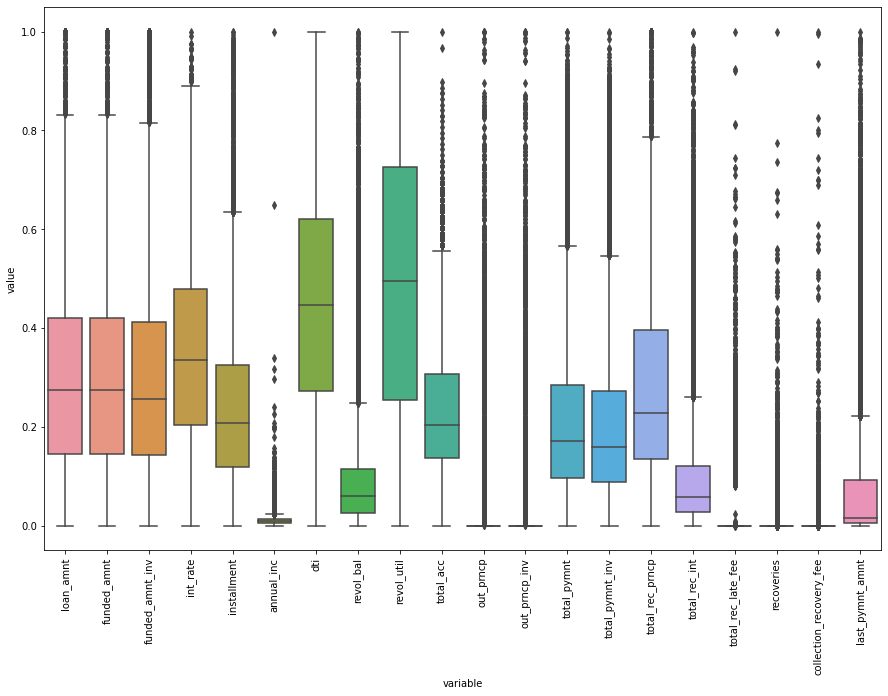

In [26]:
plt.figure(figsize=(15,10))
sns.boxplot(x="variable", y="value", data=pd.melt(scaled_data))
plt.xticks(rotation=90)
plt.show()

In [51]:
#we see that loan_amount,funded_amnt and inv_funded_amnt have similar trend in outliers and distribution - it is suggestive of interdependency 
# We see that all the above shown variables have outliers
#lets identify the pattern before we classify them as outliers
#Creating Outlier_Detector 
def IQR_outlier_detector(df:pd.DataFrame,col:str):
    third_quartile=df[col].quantile(.75)
    first_quartile=df[col].quantile(.25)
    IQR=third_quartile-first_quartile
    upper_bound=third_quartile + (1.5*IQR)
    lower_bound=first_quartile - (1.5*IQR)
    return (upper_bound,lower_bound)
def stdv_outlier_detector(df:pd.DataFrame,col:str):
    stdev=df[col].std()
    mean=df[col].mean()
    ub=mean+stdev
    lb=mean-stdev
    return (ub,lb)
def outlier_treatment(df:pd.DataFrame,col:str):
    perc=df[(df[col]>=lb)&(df[col]<=ub)].shape[0]/df.shape[0]
    if perc>=.68:
        return stdv_outlier_detector(df,col)
    else:
        return IQR_outlier_detector(df,col)
        


In [53]:
#Getting outlier bounds of loan amount column
#Slicing the data based on it
upper_bound,lower_bound=outlier_treatment(ft_data,"loan_amnt")
potential_outlier_data=ft_data[ft_data.loan_amnt>upper_bound]

In [54]:
potential_outlier_data.loan_status.value_counts()

Fully Paid     4901
Charged Off    1137
Current         443
Name: loan_status, dtype: int64

In [203]:
ft_data.title.map(lambda x:x.lower()).value_counts()[:20]

debt consolidation           3013
debt consolidation loan      1820
personal loan                 958
consolidation                 724
home improvement              525
personal                      517
credit card consolidation     470
credit card loan              344
small business loan           343
consolidation loan            341
loan                          307
home improvement loan         274
car loan                      258
wedding loan                  242
credit card payoff            214
consolidate                   205
credit card refinance         200
wedding                       188
other loan                    184
my loan                       175
Name: title, dtype: int64